# Calibrate the two cameras

In [4]:
# from https://github.com/niconielsen32/ComputerVision/blob/master/cameraCalibration.py
# modified
import scipy
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import glob

img_path = 'assets/calibration_new/'
np.set_printoptions(precision=9,suppress=True)

################ FIND CHESSBOARD CORNERS - OBJECT POINTS AND IMAGE POINTS #############################

chessboardSize = (7,5)
frameSize = (3648,2736)
#frameSize = (1600,1200)
size_of_chessboard_squares_mm = 29.15

# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

def calibrate(file_selector, index, out_path):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboardSize[0] * chessboardSize[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboardSize[0],0:chessboardSize[1]].T.reshape(-1,2)

    
    objp = objp * size_of_chessboard_squares_mm


    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.


    images = glob.glob(img_path + file_selector + "-*.jpg")

    for image in images:

        img = cv.imread(image)
        img = cv.resize(img, frameSize)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

        # Find the chess board corners
        ret, corners = cv.findChessboardCorners(gray, chessboardSize, None)

        # If found, add object points, image points (after refining them)
        print(ret)
        if ret == True:

            objpoints.append(objp)
            corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners)


    ############## CALIBRATION #######################################################

    ret, cameraMatrix, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, frameSize, None, None)

    #print("ImgPoints: ", imgpoints)

    print('')

    print("Camera calibrated: ", ret)
    print("Camera Matrix: ", cameraMatrix)
    print("Distortion Parameters: ", dist)
    print("Rotation Vectors: ", rvecs)
    print("Translation Vectors: ", tvecs)
    
    # ===========================  Calculate P  ==============================
    R = cv.Rodrigues(rvecs[index])[0]
    t = tvecs[index]
    W = np.concatenate([R,t], axis=-1) # [R|t]
    K = cameraMatrix
    P = K.dot(W)
    print('P for '+ file_selector + str(index))
    print(P)
    return P,cameraMatrix


    ############## UNDISTORTION #####################################################

    #img = cv.imread(img_path + file_selector + "-0" + str(index+1) + ".jpg")
    #h,  w = img.shape[:2]
    #newCameraMatrix, roi = cv.getOptimalNewCameraMatrix(cameraMatrix, dist, (w,h), 1, (w,h))


    # Undistort
    #dst = cv.undistort(img, cameraMatrix, dist, None, newCameraMatrix)

    # crop the image
    #x, y, w, h = roi
    #dst = dst[y:y+h, x:x+w]
    #cv.imwrite(out_path, dst)



# Undistort with Remapping
#mapx, mapy = cv.initUndistortRectifyMap(cameraMatrix, dist, None, newCameraMatrix, (w,h), 5)
#dst = cv.remap(img, mapx, mapy, cv.INTER_LINEAR)

# crop the image
#x, y, w, h = roi
#dst = dst[y:y+h, x:x+w]
#cv.imwrite('caliResult2.png', dst)




# Reprojection Error
#mean_error = 0

#for i in range(len(objpoints)):
#    imgpoints2, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], cameraMatrix, dist)
#    error = cv.norm(imgpoints[i], imgpoints2, cv.NORM_L2)/len(imgpoints2)
#    mean_error += error

#print( "total error: {}".format(mean_error/len(objpoints)) )


In [6]:
P, K1 = calibrate("img", 3, "assets/img01.jpg")
#Pp, K2 = calibrate("img", 4, "assets/img02.jpg")
#(P,Pp)
P

True
True
True
True
True
True
True
True
True
True

Camera calibrated:  0.4178394466041499
Camera Matrix:  [[2790.294372464    0.          1827.292165548]
 [   0.          2794.318008548 1402.015525105]
 [   0.             0.             1.         ]]
Distortion Parameters:  [[ 0.276835049 -2.987342034  0.000200696  0.000459854  6.718396197]]
Rotation Vectors:  (array([[-0.741706646],
       [-0.008120225],
       [-0.182648646]]), array([[-0.689999998],
       [-0.0743859  ],
       [-0.096006657]]), array([[-0.624043789],
       [-0.097631426],
       [-0.298053018]]), array([[-0.761454365],
       [ 0.475764108],
       [ 1.298924242]]), array([[-0.205764957],
       [ 0.42302761 ],
       [ 1.380929914]]), array([[-0.38922491 ],
       [ 0.516165039],
       [ 1.495358733]]), array([[-0.502829282],
       [ 0.020669438],
       [-0.270155395]]), array([[-0.631370066],
       [ 0.225574234],
       [ 0.904118162]]), array([[-0.316729012],
       [ 0.553199823],
       [ 1.602964387]]

array([[   -650.164351044,   -3128.494495281,     956.319953208,
        1717675.643218846],
       [    906.042020235,     -92.983881038,    2990.702680135,
         695757.294986894],
       [     -0.701240357,      -0.232316321,       0.674011193,
            843.000826879]])

Tcv [[ 0.410989537]
 [ 0.497147289]
 [-0.764153963]
 [ 0.000945733]]
Tf [ 914485.034800301 1526696.401465992 -811791.762085288]
Sanity (P) [[   1740.975004553   -2366.424159948    1579.171471562 1763360.838292893]
 [   1087.610127125    1426.298230498    2560.593737636  846550.725411849]
 [     -0.27498646       -0.387220095       0.880024457    1034.114166877]]
Sanity (K) [[ 1.740975005e+03 -2.366424160e+03  1.579171472e+03  1.068302098e+09]
 [ 1.087610127e+03  1.426298230e+03  2.560593738e+03  3.127930853e+09]
 [-2.749864603e-01 -3.872200954e-01  8.800244567e-01 -8.117917621e+05]]
C [ 434.57236615   525.673901369 -808.001580546]
Tcv [[ 0.499684506]
 [-0.027220447]
 [-0.865779228]
 [ 0.000877353]]
Tf [-902389.434440768 2255973.21355857  -784584.426988578]
Sanity (P) [[   -382.254433574   -2536.676367451    2131.641236861 2242526.328206918]
 [   1956.707986853     666.187898555    2345.495738255 1220806.677542427]
 [     -0.40675463        0.103658852       0.907637325    1130.54134222

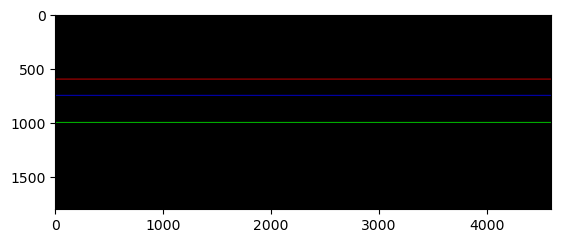

In [11]:
def factorize(P):
    M = P[:,0:3]
    
    out = cv.decomposeProjectionMatrix(P)
    K,R,T = out[0],out[1],out[2]
    K = K / K[2,2]
    print("Tcv", T)
    T = R.dot(P[:,3])
    print("Tf", T)
    
    C = np.dot(-scipy.linalg.inv(M),P[:,3])
    print("Sanity (P)", P) 
    print("Sanity (K)", K.dot(np.concatenate((R,T.reshape(-1,1)), axis=1)))
    print("C", C)
    return(K,R,C)

def plotLine(img, height, color):
    cv.line(img, (0,height), (4600,height), color, 5)

def fusiello(Mpl,Mpr, imgL_path, imgR_path, out_path=None):  
    Kl,Rl,Cl = factorize(Mpl)
    Kr,Rr,Cr = factorize(Mpr)
    print(Kl)
    print(Rl)
    print(Cl)
    x = Cl-Cr
    y = np.array(x)
    y[0]=-x[1]
    y[1]=x[0]
    z = np.cross(x,y)
    print("x", x)
    print("y", y)
    x = x/np.linalg.norm(x)
    y = y/np.linalg.norm(y)
    z = z/np.linalg.norm(z)
    Rs = np.array([x,y,z])
    tls = -Rs.dot(Cl).reshape(-1,1)
    trs = -Rs.dot(Cr).reshape(-1,1)
    print("Rs", Rs)
    print(tls)
    print(trs)
    #print(Rs)
    Ks = (Kl+Kr)/2
    Ks[0,1]=0
    Mls = Ks.dot(np.concatenate((Rs, tls), axis=1))
    Mrs = Ks.dot(np.concatenate((Rs, trs), axis=1))
    print("Mrs",Mrs)
    print("Mls",Mls)
    TFusl = Ks.dot(Rs).dot(np.linalg.inv(Kl.dot(Rl)))
    TFusr = Ks.dot(Rs).dot(np.linalg.inv(Kr.dot(Rr)))
    print("TFusl",TFusl)
    print("TFusr",TFusr)
    
    imgL=cv.imread(imgL_path)
    imgL = cv.resize(imgL,(1600,1200))
    imgR=cv.imread(imgR_path)
    imgR = cv.resize(imgR,(1600,1200))
    
    #cv.warpPerspective(imgL)
    outL = cv.warpPerspective(imgL,TFusl,(2300,1800),flags=cv.INTER_LINEAR)
    outR = cv.warpPerspective(imgR,TFusr,(2300,1800),flags=cv.INTER_LINEAR)
    out = cv.hconcat([outL,outR])
    plotLine(out, 600, (255, 0, 0))
    plotLine(out, 750, (0, 0, 255))
    plotLine(out, 1000, (0, 255, 0))
    if(out_path):
        cv.imwrite(out_path, out)
    plt.imshow(out)
    
    
fusiello(P, Pp, "assets/calibration_new/img-03.jpg", "assets/calibration_new/img-04.jpg", 'assets/fusiello.jpg')

In [29]:
Pp = np.array([[ 6.12430486e+02, -9.29557380e+02,  8.04197963e+02,
         9.98847541e+05],
       [ 8.35836177e+02,  5.46965600e+02,  6.29515656e+02,
         4.76432546e+05],
       [ 3.87999651e-04, -1.16635373e-01,  9.93174727e-01,
         7.88766677e+02]])
P = np.array([[-2.07810101e+02, -9.57532647e+02,  9.19420275e+02,
         4.99058538e+05],
       [ 6.41846643e+02,  1.77844561e+02,  9.33546842e+02,
         6.25080797e+05],
       [-3.98103114e-01,  4.43355772e-03,  9.17329959e-01,
         7.76363781e+02]])



print("P\n",P)
print("Pp\n",Pp)

P
 [[-2.07810101e+02 -9.57532647e+02  9.19420275e+02  4.99058538e+05]
 [ 6.41846643e+02  1.77844561e+02  9.33546842e+02  6.25080797e+05]
 [-3.98103114e-01  4.43355772e-03  9.17329959e-01  7.76363781e+02]]
Pp
 [[ 6.12430486e+02 -9.29557380e+02  8.04197963e+02  9.98847541e+05]
 [ 8.35836177e+02  5.46965600e+02  6.29515656e+02  4.76432546e+05]
 [ 3.87999651e-04 -1.16635373e-01  9.93174727e-01  7.88766677e+02]]
